> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, estimate the parameters.

> We select the last 32 time steps of a 32 x 32 grid of a solution of ASDM. The Training dataset includes all grid's data point.

> The free parameters of the model are fixed.

> The goal here is overfitting the model to re-create the exact output from the mtrained model. Therefore, we can be sure about the code and the selected architecture.

In [1]:
%config Completer.use_jedi = False

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"


In [3]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, 
                 x_obs, y_obs, t_obs, a_obs, s_obs, 
                 x_pde, y_pde, t_pde,
                 layers,
                 x_boundary_LB = None, y_boundary_LB = None, t_boundary_LB= None, 
                 x_boundary_TR= None, y_boundary_RT= None, t_boundary_RT= None): 
        
        if x_boundary_LB is None or \
           x_boundary_TR is None or \
           y_boundary_LB is None or \
           y_boundary_RT is None or \
           t_boundary_LB is None or \
           t_boundary_RT is None:
            self.flg_boundary = False
        else:
            self.flg_boundary = True
        
        
        with tf.device(txt_device):
                 
            X = np.concatenate([x_obs, y_obs, t_obs], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x_obs = X[:,0:1]
            self.y_obs = X[:,1:2]
            self.t_obs = X[:,2:3]

            self.a_obs = a_obs
            self.s_obs = s_obs
            
            X = np.concatenate([x_pde, y_pde, t_pde], 1)
            
            self.x_pde = x_pde
            self.y_pde = y_pde
            self.t_pde = t_pde
            
            self.lb = np.amin(np.c_[X.min(0), self.lb], 1)
            self.ub = np.amax(np.c_[X.max(0), self.ub], 1)
            
            self.x_pde = X[:,0:1]
            self.y_pde = X[:,1:2]
            self.t_pde = X[:,2:3]
            
            if self.flg_boundary:
                X = np.concatenate([x_boundary_LB, y_boundary_LB, t_boundary_LB], 1)
            
                self.lb = np.amin(np.c_[X.min(0), self.lb], 1)
                self.ub = np.amax(np.c_[X.max(0), self.ub], 1)
            
                self.x_boundary_LB = X[:,0:1]
                self.y_boundary_LB = X[:,1:2]
                self.t_boundary_LB = X[:,2:3]
            
            
                X = np.concatenate([x_boundary_TR, y_boundary_TR, t_boundary_TR], 1)
            
                self.lb = np.amin(np.c_[X.min(0), self.lb], 1)
                self.ub = np.amax(np.c_[X.max(0), self.ub], 1)
            
                self.x_boundary_TR = X[:,0:1]
                self.y_boundary_TR = X[:,1:2]
                self.t_boundary_TR = X[:,2:3]           

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_a", 
                                   constraint= lambda z: tf.clip_by_value(z, 1e-6, 1e10))#tf.constant(0.005, dtype=tf.float32)#
            self.D_s = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_s",
                                  constraint= lambda z: tf.clip_by_value(z, 1e-6, 1e10))#tf.constant(0.2, dtype=tf.float32)#
            self.sigma_a = tf.Variable([0.0], dtype=tf.float32,
                                      name="sigma_a",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.0, dtype=tf.float32, name="sigma_a")#
            self.sigma_s = tf.Variable([1.00], dtype=tf.float32, 
                                       name="sigma_s",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.mu_a = tf.Variable([1.00], dtype=tf.float32, 
                                    name="mu_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_a = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_a",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_s = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_s",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.kappa_a = tf.Variable([1.00], dtype=tf.float32,
                                       name="kappa_a",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.25, dtype=tf.float32)##

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_obs_tf = tf.placeholder(tf.float32, shape=[None, self.x_obs.shape[1]], name="x_obs_tf")
        self.y_obs_tf = tf.placeholder(tf.float32, shape=[None, self.y_obs.shape[1]], name="y_obs_tf")
        self.t_obs_tf = tf.placeholder(tf.float32, shape=[None, self.t_obs.shape[1]], name="t_obs_tf")

        self.a_obs_tf = tf.placeholder(tf.float32, shape=[None, self.a_obs.shape[1]], name="a_obs_tf")
        self.s_obs_tf = tf.placeholder(tf.float32, shape=[None, self.s_obs.shape[1]], name="s_obs_tf")
        
        
        self.x_pde_tf = tf.placeholder(tf.float32, shape=[None, self.x_pde.shape[1]], name="x_pde_tf")
        self.y_pde_tf = tf.placeholder(tf.float32, shape=[None, self.y_pde.shape[1]], name="y_pde_tf")
        self.t_pde_tf = tf.placeholder(tf.float32, shape=[None, self.t_pde.shape[1]], name="t_pde_tf")
        
        
        if self.flg_boundary:
            self.x_boundary_LB_tf = tf.placeholder(tf.float32, shape=[None, self.x_boundary_LB.shape[1]], name="x_boundary_LB_tf")
            self.y_boundary_LB_tf = tf.placeholder(tf.float32, shape=[None, self.y_boundary_LB.shape[1]], name="y_boundary_LB_tf")
            self.t_boundary_LB_tf = tf.placeholder(tf.float32, shape=[None, self.t_boundary_LB.shape[1]], name="t_boundary_LB_tf")
        
            self.x_boundary_TR_tf = tf.placeholder(tf.float32, shape=[None, self.x_boundary_TR.shape[1]], name="x_boundary_TR_tf")
            self.y_boundary_TR_tf = tf.placeholder(tf.float32, shape=[None, self.y_boundary_TR.shape[1]], name="y_boundary_TR_tf")
            self.t_boundary_TR_tf = tf.placeholder(tf.float32, shape=[None, self.t_boundary_TR.shape[1]], name="t_boundary_TR_tf")

        # Observations
        self.a_pred, self.s_pred = self.net_ASDM(self.x_obs_tf, self.y_obs_tf, self.t_obs_tf)
        # PDE's Residuals
        self.a_pde_pred, self.s_pde_pred = self.net_ASDM(self.x_pde_tf, self.y_pde_tf, self.t_pde_tf)
        self.a_res_pde, self.s_res_pde = self.net_grads(self.a_pde_pred, self.s_pde_pred, self.x_pde_tf, self.y_pde_tf, self.t_pde_tf)
        # Boundary conditions
        if self.flg_boundary:
            self.a_boundary_LB, self.s_boundary_LB = self.net_ASDM(self.x_boundary_LB_tf, self.y_boundary_LB_tf, self.t_boundary_LB_tf)
            self.a_boundary_TR, self.s_boundary_TR = self.net_ASDM(self.x_boundary_TR_tf, self.y_boundary_TR_tf, self.t_boundary_TR_tf)
        
        
        # Losses
        # Observation loss
        self.loss_obs = tf.reduce_sum(tf.square(self.a_obs_tf - self.a_pred)) + \
                        tf.reduce_sum(tf.square(self.s_obs_tf - self.s_pred)) 
        # PDE residuals loss
        self.loss_pde_a = tf.reduce_sum(tf.square(self.a_res_pde), name = "loss_pde_a")
        self.loss_pde_s = tf.reduce_sum(tf.square(self.s_res_pde), name = "loss_pde_s")
        # Boundary condition loss
        if self.flg_boundary:
            self.loss_boundary_a = tf.reduce_sum(tf.square(self.a_boundary_LB - self.a_boundary_TR)
                                                 ,name = "loss_boundary_a")
            self.loss_boundary_s = tf.reduce_sum(tf.square(self.s_boundary_LB - self.s_boundary_TR)
                                                 ,name = "loss_boundary_s")
        

        # Total loss
        self.loss = self.loss_obs + self.loss_pde_a + self.loss_pde_s
        if flg_boundary:
            self.loss +=  self.loss_boundary_a + self.loss_boundary_s
        # Optimiser
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):        
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")              
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")                
        
        return a, s
    
    def net_grads(self, a, s, x, y, t):
        
        a_t = tf.gradients(a, t)[0]
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        
        s_t = tf.gradients(s, t)[0]
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        
        
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        f = a*a*s/(1 + kappa_a*a*a)
        f_a = a_t - (a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - (s_xx + s_yy) + rho_s*f - sigma_s
        
        return f_a, f_s
        
    
    def callback(self, loss, loss_obs, loss_pde_a, loss_pde_s, 
                 D_a, D_s, sigma_a, sigma_s,
                 rho_a, rho_s, mu_a, kappa_a,
                 loss_boundary_a, loss_boundary_s):
        print(f"loss: {loss.tolist()}, loss_obs: {loss_obs.tolist()},\n"
              f"loss_a: {loss_pde_a.tolist()}, loss_s: {loss_pde_s.tolist()},\n"
              f"loss_boundary_a: {loss_boundary_a}, loss_boundary_s: {loss_boundary_s},\n"
              f"D_a: {D_a.tolist()}, D_s: {D_s.tolist()}\n"
              f"sigma_a: {sigma_a.tolist()}, sigma_s: {sigma_s.tolist()}\n"
              f"rho_a: {rho_a.tolist()}, rho_s: {rho_s.tolist()}\n"
              f"mu_a: {mu_a.tolist()}, kappa_a: {kappa_a.tolist()}\n")
        
      
    def train_batch(self, nIter, batch_size, early_stop_thresh = None, print_iter = 100):
        
        data_n = self.x_obs.shape[0]
        batch_steps = data_n//batch_size
        batch_steps = batch_steps + (data_n-1)//(batch_steps*batch_size)
        
        pde_n = self.x_pde.shape[0]
        pde_batch_size = pde_n//batch_steps        
        
        if self.flg_boundary:
            boundary_n = self.x_boundary_LB.shape[0]        
            boundary_batch_size = boundary_n//batch_steps
        
        
        data = np.concatenate([self.x_obs, self.y_obs, self.t_obs, self.a_obs, self.s_obs], 1)
        pde = np.concatenate([self.x_pde, self.y_pde, self.t_pde], 1)
        if self.flg_boundary:
            boundary_LB = np.concatenate([self.x_boundary_LB, self.y_boundary_LB, self.t_boundary_LB], 1)
            boundary_TR = np.concatenate([self.x_boundary_TR, self.y_boundary_TR, self.t_boundary_TR], 1)
        
        indices_data = np.array(list(range(data_n)))
        indices_pde = np.array(list(range(pde_n)))
        if self.flg_boundary:
            indices_boundary = np.array(list(range(boundary_n)))
        
        arr_total_loss = np.zeros(nIter)
        arr_total_loss_obs = np.zeros(nIter)
        arr_total_loss_pde_a = np.zeros(nIter)
        arr_total_loss_pde_s = np.zeros(nIter)
        if self.flg_boundary:
            arr_total_loss_boundary_a = np.zeros(nIter)
            arr_total_loss_boundary_s = np.zeros(nIter)
        
        arr_D_a = np.zeros(nIter)
        arr_D_s = np.zeros(nIter)
        arr_sigma_a = np.zeros(nIter)
        arr_sigma_s = np.zeros(nIter)
        arr_rho_a = np.zeros(nIter)
        arr_rho_s = np.zeros(nIter)
        arr_mu_a = np.zeros(nIter)
        arr_kappa_a = np.zeros(nIter)
        
        def _get_val(item):
            val = item.tolist()
            if type(val) is float:
                return val
            else:
                return val[0]
        
        start_time = time.time()
        for it in range(nIter):
            # Shuflle the batches in each epoch
            np.random.shuffle(indices_data)
            np.random.shuffle(indices_pde)
            np.random.shuffle(indices_boundary)
            
            total_loss = 0
            total_loss_obs = 0
            total_loss_pde_a = 0
            total_loss_pde_s = 0
            total_loss_boundary_a = 0
            total_loss_boundary_s = 0
            
            for batch in range(batch_steps):
                data_start = batch*batch_size
                data_end = (batch+1)*batch_size
                data_end = data_end - (data_end//data_n)*(data_end%data_n)
                
                pde_start = batch*pde_batch_size
                pde_end = (batch+1)*pde_batch_size
                #pde_end -= (pde_end//pde_n)*(pde_end%pde_n)                                
                if self.flg_boundary:
                    boundary_start = batch*boundary_batch_size
                    boundary_end = (batch+1)*boundary_batch_size
                #boundary_end -= (boundary_end//boundary_n)*(boundary_end%boundary_n) 
                # Correction for other batch at last step
                if batch == batch_steps-1:
                    if pde_end < pde_n:
                        pde_end = pde_n
                        
                    if self.flg_boundary and boundary_end < boundary_n:
                        boundary_end = boundary_n
                        
                
                #print(f"Batch:{batch}, data:{data_start}-{data_end}, "
                #     f"data:{pde_start}-{pde_end}, "
                #     f"data:{boundary_start}-{boundary_end}")
                
                batch_indices_data = indices_data[data_start:data_end]
                batch_indices_pde = indices_pde[pde_start:pde_end]
                if self.flg_boundary:
                    batch_indices_boundary = indices_boundary[boundary_start:boundary_end]
                
                tf_dict = {self.x_obs_tf: data[batch_indices_data, 0:1], 
                           self.y_obs_tf: data[batch_indices_data, 1:2], 
                           self.t_obs_tf: data[batch_indices_data, 2:3],
                           self.a_obs_tf: data[batch_indices_data, 3:4], 
                           self.s_obs_tf: data[batch_indices_data, 4:5],
                           self.x_pde_tf: pde[batch_indices_pde, 0:1],
                           self.y_pde_tf: pde[batch_indices_pde, 1:2],
                           self.t_pde_tf: pde[batch_indices_pde, 2:3]}
                if self.flg_boundary:
                    tf_dict = {**tf_dict , 
                               **{self.x_boundary_LB_tf: boundary_LB[batch_indices_boundary, 0:1],
                                  self.y_boundary_LB_tf: boundary_LB[batch_indices_boundary, 1:2],
                                  self.t_boundary_LB_tf: boundary_LB[batch_indices_boundary, 2:3],
                                  self.x_boundary_TR_tf: boundary_TR[batch_indices_boundary, 0:1],
                                  self.y_boundary_TR_tf: boundary_TR[batch_indices_boundary, 1:2],
                                  self.t_boundary_TR_tf: boundary_TR[batch_indices_boundary, 2:3]}
                              }
                
                
                self.sess.run(self.train_op_Adam, tf_dict)
            
                loss_value = _get_val(self.sess.run(self.loss, tf_dict))
                loss_obs_value = _get_val(self.sess.run(self.loss_obs, tf_dict))
                loss_pde_a_value = _get_val(self.sess.run(self.loss_pde_a, tf_dict))
                loss_pde_s_value = _get_val(self.sess.run(self.loss_pde_s, tf_dict))
                if self.flg_boundary:
                    loss_boundary_a_value = _get_val(self.sess.run(self.loss_boundary_a, tf_dict))
                    loss_boundary_s_value = _get_val(self.sess.run(self.loss_boundary_s, tf_dict))
                
                total_loss += loss_value
                total_loss_obs += loss_obs_value
                total_loss_pde_a += loss_pde_a_value
                total_loss_pde_s += loss_pde_s_value
                if self.flg_boundary:
                    total_loss_boundary_a += loss_boundary_a_value
                    total_loss_boundary_s += loss_boundary_s_value
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time                
                D_a_value = _get_val(self.sess.run(self.D_a))
                D_s_value = _get_val(self.sess.run(self.D_s))             
                sigma_a_value = _get_val(self.sess.run(self.sigma_a))
                sigma_s_value = _get_val(self.sess.run(self.sigma_s))              
                rho_a_value = _get_val(self.sess.run(self.rho_a))
                rho_s_value = _get_val(self.sess.run(self.rho_s))
                mu_a_value = _get_val(self.sess.run(self.mu_a))
                kappa_a_value = _get_val(self.sess.run(self.kappa_a))
                
                
                print(f"It: {it}, loss:{total_loss:.2f}, loss_obs:{total_loss_obs:.8f}, \n"
                      f"loss_pde_a: {total_loss_pde_a:.8f}, loss_pde_s: {total_loss_pde_s:.8f}, \n"
                      f"loss_boundary_a: {total_loss_boundary_a:.8f}, loss_boundary_s: {total_loss_boundary_s:.8f}, \n"
                      f"D_a: {D_a_value:.8f}, D_s: {D_s_value:.8f}\n"
                      f"sigma_a: {sigma_a_value:.8f}, sigma_s: {sigma_s_value:.8f}\n"
                      f"rho_a: {rho_a_value:.8f}, rho_s: {rho_s_value:.8f}\n"
                      f"mu_a: {mu_a_value:.8f}, kappa_a: {kappa_a_value:.8f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
            # early stop
            if early_stop_thresh is not None and early_stop_thresh >= total_loss:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time                    
                D_a_value = _get_val(self.sess.run(self.D_a))
                D_s_value = _get_val(self.sess.run(self.D_s))             
                sigma_a_value = _get_val(self.sess.run(self.sigma_a))
                sigma_s_value = _get_val(self.sess.run(self.sigma_s))              
                rho_a_value = _get_val(self.sess.run(self.rho_a))
                rho_s_value = _get_val(self.sess.run(self.rho_s))
                mu_a_value = _get_val(self.sess.run(self.mu_a))
                kappa_a_value = _get_val(self.sess.run(self.kappa_a))
                
                                                
                print(f"It: {it}, loss:{total_loss:.2f}, loss_obs:{total_loss_obs:.8f}, \n"
                      f"loss_pde_a: {total_loss_pde_a:.8f}, loss_pde_s: {total_loss_pde_s:.8f}, \n"
                      f"loss_boundary_a: {total_loss_boundary_a:.8f}, loss_boundary_s: {total_loss_boundary_s:.8f}, \n"
                      f"D_a: {D_a_value:.8f}, D_s: {D_s_value:.8f}\n"
                      f"sigma_a: {sigma_a_value:.8f}, sigma_s: {sigma_s_value:.8f}\n"
                      f"rho_a: {rho_a_value:.8f}, rho_s: {rho_s_value:.8f}\n"
                      f"mu_a: {mu_a_value:.8f}, kappa_a: {kappa_a_value:.8f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
                arr_total_loss[it] = total_loss
                arr_total_loss_obs[it] = total_loss_obs
                arr_total_loss_pde_a[it] = total_loss_pde_a
                arr_total_loss_pde_s[it] = total_loss_pde_s
                if self.flg_boundary:
                    arr_total_loss_boundary_a[it] = total_loss_boundary_a
                    arr_total_loss_boundary_s[it] = total_loss_boundary_s
                arr_D_a[it] = D_a_value
                arr_D_s[it] = D_s_value                
                arr_sigma_a[it] = sigma_a_value                                                                                                                        
                arr_sigma_s[it] = sigma_s_value
                arr_rho_a[it] = rho_a_value
                arr_rho_s[it] = rho_s_value
                arr_mu_a[it] = mu_a_value
                arr_kappa_a[it] = kappa_a_value                
                                
                losses = {'total_loss': arr_total_loss[:(it+1)],
                          'loss_obs': arr_total_loss_obs[:(it+1)],
                          'loss_pde_a': arr_total_loss_pde_a[:(it+1)],
                          'loss_pde_s': arr_total_loss_pde_s[:(it+1)]                          
                          }
                if self.flg_boundary:
                    losses = {**losses, 
                              **{'loss_boundary_a': arr_total_loss_boundary_a[:(it+1)],
                                 'loss_boundary_s': arr_total_loss_boundary_s[:(it+1)]}
                             }
                params = {'D_a': arr_D_a[:(it+1)], 'D_s': arr_D_s[:(it+1)],
                          'sigma_a': arr_sigma_a[:(it+1)] , 'sigma_s': arr_sigma_s[:(it+1)],
                          'rho_a' : arr_rho_a[:(it+1)], 'rho_s' : arr_rho_s[:(it+1)],
                          'mu_a': arr_mu_a[:(it+1)], 'kappa_a': arr_kappa_a[:(it+1)]}
                
                return (losses, params)    
        
            arr_total_loss[it] = total_loss
            arr_total_loss_obs[it] = total_loss_obs
            arr_total_loss_pde_a[it] = total_loss_pde_a
            arr_total_loss_pde_s[it] = total_loss_pde_s
            if self.flg_boundary:
                arr_total_loss_boundary_a[it] = total_loss_boundary_a
                arr_total_loss_boundary_s[it] = total_loss_boundary_s
            arr_D_a[it] = D_a_value
            arr_D_s[it] = D_s_value            
            arr_sigma_a[it] = sigma_a_value
            arr_sigma_s[it] = sigma_s_value
            arr_rho_a[it] = rho_a_value
            arr_rho_s[it] = rho_s_value
            arr_mu_a[it] = mu_a_value
            arr_kappa_a[it] = kappa_a_value
            
        # end for it
        losses = {'total_loss': arr_total_loss,
                  'loss_obs': arr_total_loss_obs,
                  'loss_pde_a': arr_total_loss_pde_a,
                  'loss_pde_s': arr_total_loss_pde_s
                 }
        if self.flg_boundary:
            losses = {**losses, 
                      **{'loss_boundary_a': arr_total_loss_boundary_a,
                         'loss_boundary_s': arr_total_loss_boundary_s}
                    }
        
        params = {'D_a': arr_D_a, 'D_s': arr_D_s,
                  'sigma_a': arr_sigma_a , 'sigma_s': arr_sigma_s,
                  'rho_a' : arr_rho_a, 'rho_s' : arr_rho_s, 'mu_a': arr_mu_a, 'kappa_a': arr_kappa_a}
        
        
        return (losses, params)
                
            
        
        
    def minimise(self, max_iter = None, f_tol = None):
        if max_iter is not None:
            self.optimizer.optimizer_kwargs['options']['maxiter'] = max_iter
            
        if f_tol is not None:
            self.optimizer.optimizer_kwargs['options']['f_tol'] = f_tol
        
        
        tf_dict = {self.x_obs_tf: self.x_obs, self.y_obs_tf: self.y_obs, self.t_obs_tf: self.t_obs,
                   self.a_obs_tf: self.a_obs, self.s_obs_tf: self.s_obs,
                   self.x_pde_tf: self.x_pde, self.y_pde_tf: self.y_pde, self.t_pde_tf: self.t_pde}
        if self.flg_boundary:
            tf_dict = {**tf_dict,
                       **{self.x_boundary_LB_tf: self.x_boundary_LB, 
                          self.y_boundary_LB_tf: self.y_boundary_LB, 
                          self.t_boundary_LB_tf: self.t_boundary_LB,
                          self.x_boundary_TR_tf: self.x_boundary_TR, 
                          self.y_boundary_TR_tf: self.y_boundary_TR, 
                          self.t_boundary_TR_tf: self.t_boundary_TR}
                      }
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_obs, self.loss_pde_a, self.loss_pde_s,                                           
                                           self.D_a, self.D_s,
                                           self.sigma_a, self.sigma_s,
                                           self.rho_a, self.rho_s,
                                           self.mu_a, self.kappa_a,
                                           self.loss_boundary_a.tolist() if self.flg_boundary else 0, 
                                           self.loss_boundary_s.tolist() if self.flg_boundary else 0],
                                loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_obs_tf: x_star, self.y_obs_tf: y_star, self.t_obs_tf: t_star,
                   self.x_pde_tf: self.x_pde, self.y_pde_tf: self.y_pde, self.t_pde_tf: self.t_pde}
        if self.flg_boundary:
            tf_dict = {**tf_dict,
                       **{self.x_boundary_LB_tf: self.x_boundary_LB, 
                          self.y_boundary_LB_tf: self.y_boundary_LB, 
                          self.t_boundary_LB_tf: self.t_boundary_LB,
                          self.x_boundary_TR_tf: self.x_boundary_TR, 
                          self.y_boundary_TR_tf: self.y_boundary_TR, 
                          self.t_boundary_TR_tf: self.t_boundary_TR}
                      }
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [4]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x_domain = L*np.linspace(0,1,x_size)
y_domain = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

boundary_x_LB = np.concatenate((x_domain, 
                                np.repeat(x_domain[0], y_size)))
boundary_x_TR = np.concatenate((x_domain, 
                                np.repeat(x_domain[-1], y_size))) 

boundary_y_LB = np.concatenate((np.repeat(y_domain[0], x_size),
                                y_domain))
boundary_y_TR = np.concatenate((np.repeat(y_domain[-1], x_size),
                                y_domain)) 

boundary_XX_LB = np.tile(boundary_x_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_XX_TR = np.tile(boundary_x_TR.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_LB = np.tile(boundary_y_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_TR = np.tile(boundary_y_TR.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_TT = np.repeat(t_star[-T:], (x_size + y_size))[:, np.newaxis] # T x (x_size + y_size), 1



######################################################################
######################## Noiseles Data ###############################
######################################################################
training_data_size =  T*16
pde_data_size =  (T*N)//(32)
boundary_data_size = ((x_size + y_size)*T)//(8)


# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
# 32 worked
#idx = np.random.choice(N*T, T*32, replace=False)
idx_data = np.random.choice(N*T, training_data_size, replace=False)
#idx = list(range(N*T))
x_train = x[idx_data,:]
y_train = y[idx_data,:]
t_train = t[idx_data,:]
a_train = a[idx_data,:]
s_train = s[idx_data,:]

# PDE colocations
idx_pde = np.random.choice(N*T, pde_data_size, replace=False)
#idx = list(range(N*T))
x_pde = x[idx_pde,:]
y_pde = y[idx_pde,:]
t_pde = t[idx_pde,:]

# Periodic boundary condition

idx_boundary = np.random.choice((x_size + y_size)*T, boundary_data_size, replace=False)
x_boundary_LB = boundary_XX_LB[idx_boundary]
x_boundary_TR = boundary_XX_TR[idx_boundary]
y_boundary_LB = boundary_YY_LB[idx_boundary]
y_boundary_TR = boundary_YY_TR[idx_boundary]
t_boundary_LB = boundary_TT[idx_boundary]
t_boundary_TR = boundary_TT[idx_boundary]



In [5]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train,
                          x_pde, y_pde, t_pde,
                          x_boundary_LB, y_boundary_LB, t_boundary_LB,
                          x_boundary_TR, y_boundary_TR, t_boundary_TR,
                          layers)
losses,  params_estimates = \
model.train_batch(10000, batch_size=len(idx_data)//16,  early_stop_thresh=1, print_iter=100)

It: 0, loss:32816.52, loss_obs:16827.06445312, 
loss_pde_a: 536.65997231, loss_pde_s: 15409.68774414, 
loss_boundary_a: 18.17042193, loss_boundary_s: 24.94071769, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.01560694, sigma_s: 0.98404038
rho_a: 1.01073778, rho_s: 1.01163554
mu_a: 0.98461086, kappa_a: 0.98761475, 
Time:3.75

It: 100, loss:2191.70, loss_obs:2185.84558868, 
loss_pde_a: 1.13110251, loss_pde_s: 2.54192024, 
loss_boundary_a: 1.45604067, loss_boundary_s: 0.72191046, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.09329790, sigma_s: 0.88436830
rho_a: 1.11046064, rho_s: 1.23369992
mu_a: 0.88695049, kappa_a: 0.77809459, 
Time:69.00

It: 200, loss:2188.88, loss_obs:2185.48750305, 
loss_pde_a: 0.54166436, loss_pde_s: 1.02566315, 
loss_boundary_a: 1.30803785, loss_boundary_s: 0.51440881, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.09352761, sigma_s: 0.87862074
rho_a: 1.10683334, rho_s: 1.23253751
mu_a: 0.88113058, kappa_a: 0.78696615, 
Time:68.87

It: 300, loss:2189.69, loss_obs:2185

It: 2600, loss:2186.49, loss_obs:2182.92688751, 
loss_pde_a: 0.66909548, loss_pde_s: 0.50820491, 
loss_boundary_a: 2.13308938, loss_boundary_s: 0.25483882, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.03290279, sigma_s: 0.63564998
rho_a: 1.09328592, rho_s: 1.05188990
mu_a: 0.69300801, kappa_a: 1.11416626, 
Time:68.95

It: 2700, loss:2185.37, loss_obs:2181.83544922, 
loss_pde_a: 0.24288209, loss_pde_s: 0.47240165, 
loss_boundary_a: 2.47288989, loss_boundary_s: 0.34931016, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.03071887, sigma_s: 0.62519377
rho_a: 1.09498811, rho_s: 1.04151785
mu_a: 0.68255025, kappa_a: 1.12815785, 
Time:68.85

It: 2800, loss:2186.38, loss_obs:2182.84991455, 
loss_pde_a: 0.45558066, loss_pde_s: 0.57763227, 
loss_boundary_a: 2.15736778, loss_boundary_s: 0.34354730, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.02586293, sigma_s: 0.61363673
rho_a: 1.09451008, rho_s: 1.03266466
mu_a: 0.67465991, kappa_a: 1.14305437, 
Time:68.94

It: 2900, loss:2185.73, loss_obs:2182.54

It: 5200, loss:179.77, loss_obs:125.31966066, 
loss_pde_a: 36.94112587, loss_pde_s: 2.87186015, 
loss_boundary_a: 12.74076945, loss_boundary_s: 1.89705344, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09308807
rho_a: 1.10386443, rho_s: 0.08282811
mu_a: 1.22128642, kappa_a: 0.16020294, 
Time:68.18

It: 5300, loss:164.05, loss_obs:110.31792355, 
loss_pde_a: 35.00788343, loss_pde_s: 2.75078177, 
loss_boundary_a: 14.07943204, loss_boundary_s: 1.88984326, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09383581
rho_a: 1.13790071, rho_s: 0.08329833
mu_a: 1.25383651, kappa_a: 0.16449471, 
Time:68.30

It: 5400, loss:147.52, loss_obs:98.36694193, 
loss_pde_a: 33.81445491, loss_pde_s: 2.66778615, 
loss_boundary_a: 10.84296778, loss_boundary_s: 1.82779073, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09374790
rho_a: 1.17009020, rho_s: 0.08438323
mu_a: 1.28339159, kappa_a: 0.16883394, 
Time:68.07

It: 5500, loss:134.02, loss_obs:87.657813

It: 7800, loss:52.85, loss_obs:32.46742368, 
loss_pde_a: 11.43906963, loss_pde_s: 2.30805156, 
loss_boundary_a: 5.95416400, loss_boundary_s: 0.68021009, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09524257
rho_a: 1.56839442, rho_s: 0.09116976
mu_a: 1.63003767, kappa_a: 0.21486725, 
Time:68.04

It: 7900, loss:51.41, loss_obs:31.75076568, 
loss_pde_a: 11.93866336, loss_pde_s: 2.32023609, 
loss_boundary_a: 4.67438182, loss_boundary_s: 0.72403089, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09560630
rho_a: 1.57998276, rho_s: 0.09107579
mu_a: 1.63948369, kappa_a: 0.21670063, 
Time:68.14

It: 8000, loss:48.77, loss_obs:30.97400653, 
loss_pde_a: 10.75536668, loss_pde_s: 2.28568499, 
loss_boundary_a: 4.17947571, loss_boundary_s: 0.57310567, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09577418
rho_a: 1.59129786, rho_s: 0.09146349
mu_a: 1.64847755, kappa_a: 0.21782252, 
Time:68.26

It: 8100, loss:50.74, loss_obs:31.13011265, 
loss

In [11]:
losses2,  params_estimates2 = \
model.train_batch(10000, batch_size=len(idx_data)//16,  early_stop_thresh=1, print_iter=100)

It: 0, loss:40.22, loss_obs:25.78842890, 
loss_pde_a: 7.15027416, loss_pde_s: 2.01838027, 
loss_boundary_a: 4.72634903, loss_boundary_s: 0.53798769, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09535987
rho_a: 1.72655535, rho_s: 0.09376139
mu_a: 1.75776017, kappa_a: 0.23370029, 
Time:0.72

It: 100, loss:39.20, loss_obs:25.44924080, 
loss_pde_a: 7.12134466, loss_pde_s: 1.98516218, 
loss_boundary_a: 4.10479803, loss_boundary_s: 0.54295931, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09519091
rho_a: 1.73072827, rho_s: 0.09347977
mu_a: 1.76085699, kappa_a: 0.23411283, 
Time:67.88

It: 200, loss:38.60, loss_obs:24.99515259, 
loss_pde_a: 6.94047794, loss_pde_s: 1.98447070, 
loss_boundary_a: 4.20208120, loss_boundary_s: 0.47913555, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09513763
rho_a: 1.73453808, rho_s: 0.09409940
mu_a: 1.76413810, kappa_a: 0.23436394, 
Time:67.76

It: 300, loss:41.50, loss_obs:25.61948478, 
loss_pde_a: 7.

It: 2600, loss:36.14, loss_obs:23.41666329, 
loss_pde_a: 5.83599129, loss_pde_s: 1.72292860, 
loss_boundary_a: 4.59906052, loss_boundary_s: 0.56397497, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09558580
rho_a: 1.79573178, rho_s: 0.09478387
mu_a: 1.81400263, kappa_a: 0.24066229, 
Time:67.71

It: 2700, loss:37.17, loss_obs:24.00443041, 
loss_pde_a: 5.47172013, loss_pde_s: 1.71587014, 
loss_boundary_a: 5.42873858, loss_boundary_s: 0.54978059, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09593336
rho_a: 1.79774904, rho_s: 0.09450977
mu_a: 1.81540096, kappa_a: 0.24089167, 
Time:67.83

It: 2800, loss:33.10, loss_obs:22.64313710, 
loss_pde_a: 5.04094109, loss_pde_s: 1.69974642, 
loss_boundary_a: 3.33701180, loss_boundary_s: 0.37891985, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09594415
rho_a: 1.79943693, rho_s: 0.09425446
mu_a: 1.81699157, kappa_a: 0.24121812, 
Time:67.87

It: 2900, loss:33.88, loss_obs:22.68715072, 
loss_pd

It: 5200, loss:31.23, loss_obs:21.55831045, 
loss_pde_a: 4.28977428, loss_pde_s: 1.49908694, 
loss_boundary_a: 3.49400116, loss_boundary_s: 0.39270817, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09576014
rho_a: 1.83189631, rho_s: 0.09489484
mu_a: 1.84293401, kappa_a: 0.24454781, 
Time:67.75

It: 5300, loss:30.02, loss_obs:21.16713130, 
loss_pde_a: 4.16355221, loss_pde_s: 1.49143561, 
loss_boundary_a: 2.85215846, loss_boundary_s: 0.34985578, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09566263
rho_a: 1.83305132, rho_s: 0.09520364
mu_a: 1.84389710, kappa_a: 0.24445175, 
Time:67.72

It: 5400, loss:33.39, loss_obs:21.84537643, 
loss_pde_a: 4.76401672, loss_pde_s: 1.49276062, 
loss_boundary_a: 4.80995622, loss_boundary_s: 0.47477697, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09589990
rho_a: 1.83381605, rho_s: 0.09484824
mu_a: 1.84475970, kappa_a: 0.24502628, 
Time:67.73

It: 5500, loss:31.48, loss_obs:21.56420594, 
loss_pd

It: 7800, loss:30.00, loss_obs:21.01159203, 
loss_pde_a: 4.04090814, loss_pde_s: 1.34858387, 
loss_boundary_a: 3.25927820, loss_boundary_s: 0.34068818, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09552953
rho_a: 1.85016501, rho_s: 0.09507637
mu_a: 1.85735452, kappa_a: 0.24649261, 
Time:67.83

It: 7900, loss:29.41, loss_obs:20.34325546, 
loss_pde_a: 3.97373654, loss_pde_s: 1.34161020, 
loss_boundary_a: 3.37808973, loss_boundary_s: 0.37805467, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09571463
rho_a: 1.85054004, rho_s: 0.09507708
mu_a: 1.85778332, kappa_a: 0.24652772, 
Time:67.63

It: 8000, loss:29.90, loss_obs:20.32842189, 
loss_pde_a: 3.91995674, loss_pde_s: 1.33407284, 
loss_boundary_a: 3.90978584, loss_boundary_s: 0.40889107, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00001379, sigma_s: 0.09526440
rho_a: 1.85125434, rho_s: 0.09524269
mu_a: 1.85859895, kappa_a: 0.24644512, 
Time:67.70

It: 8100, loss:28.02, loss_obs:19.83873582, 
loss_pd

In [33]:
losses2,  params_estimates2 = \
model.train_batch(10000, batch_size=len(idx_data)//16,  early_stop_thresh=10, print_iter=200)

It: 0, loss:28.83, loss_obs:20.26237392, 
loss_pde_a: 3.60454632, loss_pde_s: 1.26607370, 
loss_boundary_a: 3.33329964, loss_boundary_s: 0.36097278, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09550112
rho_a: 1.85794890, rho_s: 0.09563303
mu_a: 1.86393738, kappa_a: 0.24695025, 
Time:0.72

It: 200, loss:28.98, loss_obs:20.23485565, 
loss_pde_a: 3.42904620, loss_pde_s: 1.24301990, 
loss_boundary_a: 3.69741983, loss_boundary_s: 0.37642679, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09569784
rho_a: 1.85856736, rho_s: 0.09484375
mu_a: 1.86425877, kappa_a: 0.24738616, 
Time:135.95

It: 400, loss:27.78, loss_obs:19.61901778, 
loss_pde_a: 3.41119079, loss_pde_s: 1.23932306, 
loss_boundary_a: 3.15710099, loss_boundary_s: 0.35578134, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09588116
rho_a: 1.85923123, rho_s: 0.09481175
mu_a: 1.86467588, kappa_a: 0.24731879, 
Time:135.43

It: 600, loss:31.19, loss_obs:20.60010380, 
loss_pde_a: 

It: 5200, loss:27.55, loss_obs:19.33803135, 
loss_pde_a: 3.22062401, loss_pde_s: 1.11450343, 
loss_boundary_a: 3.45696026, loss_boundary_s: 0.41611739, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09542806
rho_a: 1.86436653, rho_s: 0.09470983
mu_a: 1.86859608, kappa_a: 0.24791507, 
Time:134.68

It: 5400, loss:27.40, loss_obs:19.01819932, 
loss_pde_a: 3.03654441, loss_pde_s: 1.10707764, 
loss_boundary_a: 3.82222565, loss_boundary_s: 0.41147620, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09527402
rho_a: 1.86475086, rho_s: 0.09490351
mu_a: 1.86875284, kappa_a: 0.24780226, 
Time:134.89

It: 5600, loss:27.00, loss_obs:19.11319816, 
loss_pde_a: 3.29954857, loss_pde_s: 1.10048995, 
loss_boundary_a: 3.11015259, loss_boundary_s: 0.37846085, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09521136
rho_a: 1.86469162, rho_s: 0.09491826
mu_a: 1.86877501, kappa_a: 0.24792656, 
Time:134.96

It: 5800, loss:27.51, loss_obs:18.75039512, 
loss

In [12]:
def merge_stats(dict_stats1, dict_stats2):
    ret = {}
    for key in dict_stats1.keys():
        ret[key] = np.r_[dict_stats1[key], dict_stats2[key]]
    return ret

In [34]:
losses = merge_stats(losses, losses2)
params_estimates = merge_stats(params_estimates, params_estimates2)

In [35]:
total_loss = losses['total_loss']
total_loss_obs = losses['loss_obs']
total_loss_pde_a = losses['loss_pde_a']
total_loss_pde_s = losses['loss_pde_s']
total_loss_boundary_a = losses['loss_boundary_a']
total_loss_boundary_s = losses['loss_boundary_s']

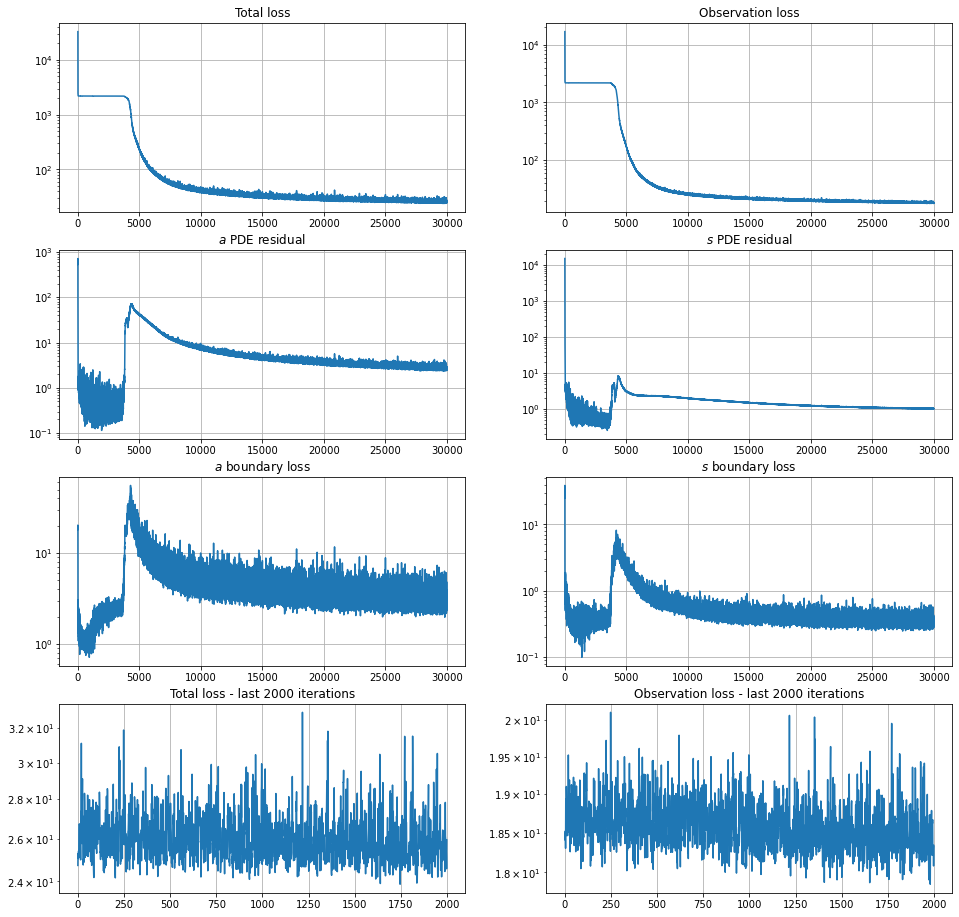

In [36]:
start = 0
end = len(total_loss)
_ = plt.figure(figsize=(16,16))

plt.subplot(4,2,1)
plt.plot(total_loss[start:end])
plt.yscale('log')
plt.title(r"Total loss")
plt.grid()

plt.subplot(4,2,2)
plt.plot(total_loss_obs[start:end])
plt.yscale('log')
plt.title(r"Observation loss")
plt.grid()


plt.subplot(4,2,3)
plt.plot(total_loss_pde_a[start:end])
plt.yscale('log')
plt.title(r"$a$ PDE residual")
plt.grid()

plt.subplot(4,2,4)
plt.plot(total_loss_pde_s[start:end])
plt.yscale('log')
plt.title(r"$s$ PDE residual")
plt.grid()

plt.subplot(4,2,5)
plt.plot(total_loss_boundary_a[start:end])
plt.yscale('log')
plt.title(r"$a$ boundary loss")
plt.grid()

plt.subplot(4,2,6)
plt.plot(total_loss_boundary_s[start:end])
plt.yscale('log')
plt.title(r"$s$ boundary loss")
plt.grid()

plt.subplot(4,2,7)
plt.plot(total_loss[-2000:])
plt.yscale('log')
plt.title(r"Total loss - last 2000 iterations")
plt.grid()

plt.subplot(4,2,8)
plt.plot(total_loss_obs[-2000:])
plt.yscale('log')
plt.title(r"Observation loss - last 2000 iterations")
plt.grid()

plt.show()

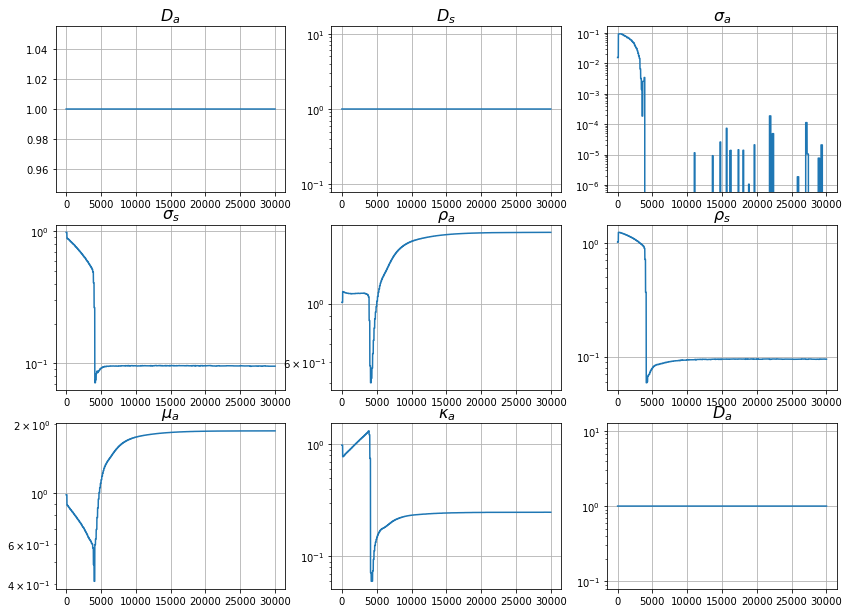

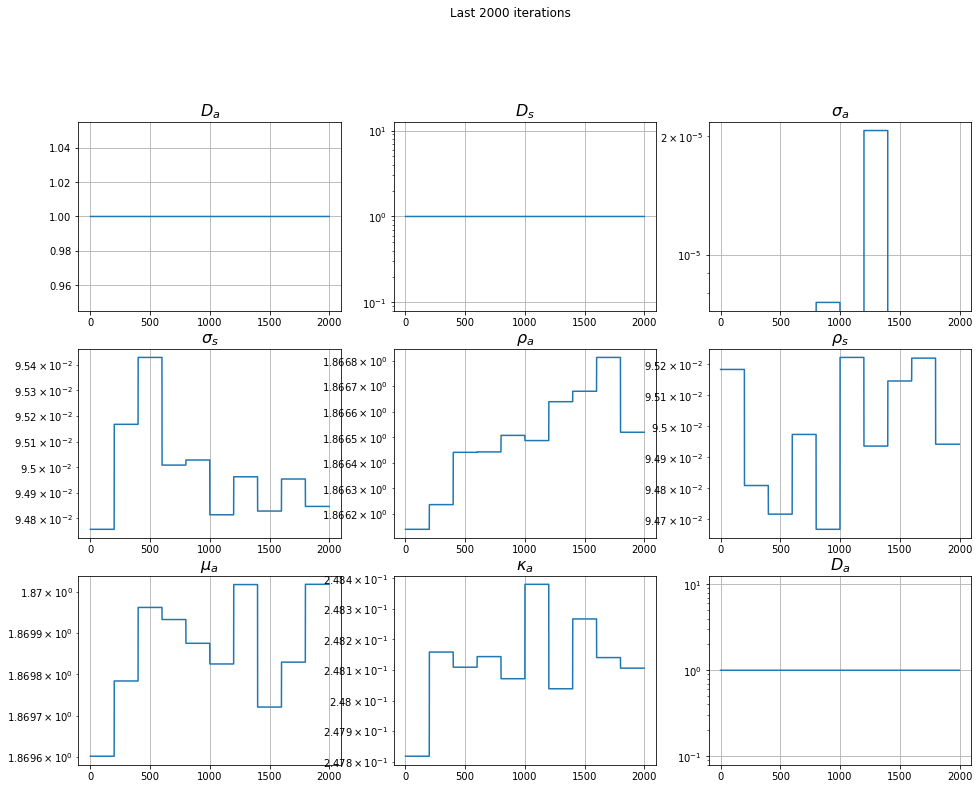

In [37]:
start = 0
end = -1
_ = plt.figure(figsize=(14,14))

plt.subplot(4,3,1)
plt.plot(params_estimates['D_a'][start:end])
plt.title(r"$D_a$", fontsize=16)
#plt.yscale('log')
plt.grid()

plt.subplot(4,3,2)
plt.plot(params_estimates['D_s'][start:end])
plt.title(r"$D_s$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,3)
plt.plot(params_estimates['sigma_a'][start:end])
plt.title(r"$\sigma_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,4)
plt.plot(params_estimates['sigma_s'][start:end])
plt.title(r"$\sigma_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.005,.04])
plt.grid()

plt.subplot(4,3,5)
plt.plot(params_estimates['rho_a'][start:end])
plt.title(r"$\rho_a$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,6)
plt.plot(params_estimates['rho_s'][start:end])
plt.title(r"$\rho_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.0,.05])
plt.grid()


plt.subplot(4,3,7)
plt.plot(params_estimates['mu_a'][start:end])
plt.title(r"$\mu_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,8)
plt.plot(params_estimates['kappa_a'][start:end])
plt.title(r"$\kappa_a$", fontsize=16)
plt.yscale('log')
#plt.ylim([0,1])
plt.grid()

plt.subplot(4,3,9)
plt.plot(params_estimates['D_a'][start:end])
plt.title(r"$D_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.show()

start = -2000
end = -1
_ = plt.figure(figsize=(16,16))

plt.suptitle("Last 2000 iterations")

plt.subplot(4,3,1)
plt.plot(params_estimates['D_a'][start:end])
plt.title(r"$D_a$", fontsize=16)
#plt.yscale('log')
plt.grid()

plt.subplot(4,3,2)
plt.plot(params_estimates['D_s'][start:end])
plt.title(r"$D_s$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,3)
plt.plot(params_estimates['sigma_a'][start:end])
plt.title(r"$\sigma_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,4)
plt.plot(params_estimates['sigma_s'][start:end])
plt.title(r"$\sigma_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.005,.04])
plt.grid()

plt.subplot(4,3,5)
plt.plot(params_estimates['rho_a'][start:end])
plt.title(r"$\rho_a$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,6)
plt.plot(params_estimates['rho_s'][start:end])
plt.title(r"$\rho_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.0,.05])
plt.grid()


plt.subplot(4,3,7)
plt.plot(params_estimates['mu_a'][start:end])
plt.title(r"$\mu_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,8)
plt.plot(params_estimates['kappa_a'][start:end])
plt.title(r"$\kappa_a$", fontsize=16)
plt.yscale('log')
#plt.ylim([0,1])
plt.grid()

plt.subplot(4,3,9)
plt.plot(params_estimates['D_a'][start:end])
plt.title(r"$D_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.show()


In [38]:
def print_vals(name, value, actual=None):
    def _get_val(item):
        val = item.tolist()
        if type(val) is float:
            return val
        else:
            return val[0]
    value = _get_val(value)
    
    if actual is not None and actual > 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/(actual):0.8f}")
    elif actual is not None and actual == 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f} ")
        
    else:
        print(f"{name}: {value:0.8f}")
    

D_a = model.sess.run(model.D_a)
D_s = model.sess.run(model.D_s)
sigma_s = model.sess.run(model.sigma_s)
rho_s = model.sess.run(model.rho_s)

sigma_a = model.sess.run(model.sigma_a)
rho_a = model.sess.run(model.rho_a)
mu_a = model.sess.run(model.mu_a)
kappa_a = model.sess.run(model.kappa_a)


print_vals("D_s", D_s, 0.2)
print_vals("sigma_s", sigma_s*0.2, 0.02)
print_vals("rho_s", rho_s*0.2, 0.02)
print()
print_vals("D_a", D_a, 0.005)
print_vals("sigma_a", sigma_a*0.005, 0.0)
print_vals("rho_a", rho_a*0.005,0.01)
print_vals("mu_a", mu_a*0.005, 0.01 )
print_vals("kappa_a", kappa_a, 0.25)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.01898427, actual: 0.020, difference: 0.00101573, relative: %5.07864393
rho_s: 0.01905281, actual: 0.020, difference: 0.00094719, relative: %4.73597310

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.00933323, actual: 0.010, difference: 0.00066677, relative: %6.66767582
mu_a: 0.00934919, actual: 0.010, difference: 0.00065081, relative: %6.50813095
kappa_a: 0.24803829, actual: 0.250, difference: 0.00196171, relative: %0.78468323


# Estimated parameters

In [39]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1#-1
t_test = 50000#t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [40]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_obs_tf: x_2, model.y_obs_tf: y_2, model.t_obs_tf: t_2, 
           model.a_obs_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_obs_tf:data[1, :, :, index].flatten()[:, np.newaxis],
           model.x_pde_tf: model.x_pde, model.y_pde_tf: model.y_pde, model.t_pde_tf: model.t_pde,
           model.x_boundary_LB_tf: model.x_boundary_LB, 
           model.y_boundary_LB_tf: model.y_boundary_LB, 
           model.t_boundary_LB_tf: model.t_boundary_LB,
           model.x_boundary_TR_tf: model.x_boundary_TR, 
           model.y_boundary_TR_tf: model.y_boundary_TR, 
           model.t_boundary_TR_tf: model.t_boundary_TR}
print( f"Loss_a : {model.sess.run(model.loss_pde_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_pde_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 2.61336803
Loss_s : 1.03168070
Loss   : 11.24900341


In [41]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

3.5453819046750192
0.3833244423958693


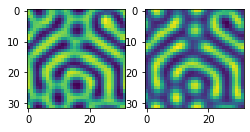

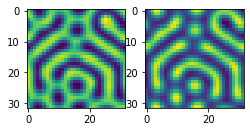

In [42]:

plt.subplot(131)
plt.imshow(a_2)
plt.subplot(132)
plt.imshow(s_2)
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.show()